In [89]:
from typing import Sequence, Optional

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

## 1.0 Intro to JAX

Jax is like numpy, but with a few key differences:
- GPU's and TPU's
- Automatic differentiation
- JIT compilation
- Vectorization/parallelization

In [90]:
import jax.numpy as jnp

In [91]:
x = jnp.array([1, 2, 3])
a = jnp.eye(3)
print(x ** 2)
print(a @ x)
print(jnp.linalg.eigvalsh(a))

[1 4 9]
[1.00 2.00 3.00]
[1.00 1.00 1.00]


### 1.1 Automatic differentiation

In [92]:
from jax import grad, value_and_grad, jacrev, jacfwd

In [93]:
def f(x):
    return x ** 3

df = grad(f)  # 3 * x ** 2
ddf = grad(df)  # 6 * x
dddf = grad(ddf)  # 6
dddf = grad(dddf)  # 0

print(f(1.0))
print(df(1.0))
print(ddf(1.0))
print(dddf(1.0))
print(dddf(1.0))

1.0
3.0
6.0
0.0
0.0


In [94]:
# f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

def f(x):
    return x[0] ** 2 + x[1] ** 2


# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jacfwd(jacrev(f))


print("Jacobian:", jacrev(f)(jnp.array([1.0, 1.0])))
print("Full Hessian: \n", hessian(f)(jnp.array([1.0, 1.0])))

Jacobian: [2.00 2.00]
Full Hessian: 
 [[2.00 0.00]
 [0.00 2.00]]


You can do that for any function that you can write with numpy

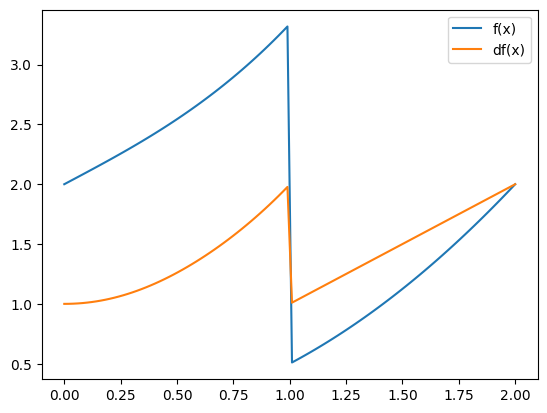

In [95]:
def f(x):
    if x < 1:
        return jnp.sin(x) + jnp.cos(x) + jnp.exp(x) - jnp.tanh(x)
    else:
        return 0.5 * x ** 2


x = jnp.linspace(0, 2, 100)
y = jnp.array([f(x_) for x_ in x])
dy = jnp.array([grad(f)(x_) for x_ in x])
plt.plot(x, y, label='f(x)')
plt.plot(x, dy, label='df(x)')
plt.legend()
plt.show()

### 1.2 Randomness

In [96]:
from jax import random

In [97]:
key = random.PRNGKey(0)
key, subkey = random.split(key)

# Use subkey, carry key around and split it when needed - helps with reproducibility and better overview of randomness!!
a = random.normal(key=subkey, shape=(3, 3))
print(a)

[[-0.39 -0.04 -2.04]
 [0.08 -0.05 0.80]
 [-1.44 -1.69 -0.37]]


### 1.3 JIT compilation

In [98]:
from jax import jit
import time

In [99]:
a = np.random.rand(10 ** 7, )
times = []


def swish(x):
    return x / (1 + np.exp(-x))


for i in range(100):
    start_time = time.time()
    b = swish(a)
    times.append(time.time() - start_time)
print(np.median(np.array(times)) * 1000, 'ms')

66.0851001739502 ms


In [100]:
key, subkey = random.split(key)
a = random.uniform(key=subkey, shape=(10 ** 7,))


def swish(x):
    return x / (1 + jnp.exp(-x))


fast_swish = jit(swish)

times = []
for i in range(100):
    start_time = time.time()
    b = swish(a)
    times.append(time.time() - start_time)
print(np.median(np.array(times)) * 1000, 'ms')

times_fast = []
for i in range(100):
    start_time = time.time()
    b = fast_swish(a)
    times_fast.append(time.time() - start_time)
print(np.median(np.array(times_fast)) * 1000, 'ms')

16.860485076904297 ms
5.621075630187988 ms


### 1.4 Vectorization

We can write a function which takes a single input and returns a single output, then when we need to apply it to several points we can just vmap-it, and it is as fast as if we were to write the vectorized version of the function

In [101]:
from jax import vmap

In [102]:
def rbf(x, y):
    assert x.shape == y.shape and x.ndim == y.ndim == 1
    return jnp.exp(-jnp.sum((x - y) ** 2))


rbf_v = vmap(rbf, in_axes=(0, None))
rbf_m = vmap(rbf_v, in_axes=(None, 0), out_axes=1)

key, *subkeys = random.split(key, 3)
xs = random.normal(subkeys[0], shape=(100, 1))
ys = random.normal(subkeys[1], shape=(14, 1))

print(rbf_v(xs, ys[0]).shape)
print(rbf_m(xs, ys).shape)

(100,)
(100, 14)


### 1.5 PyTrees

Any python structure which has jnp.arrays as leaves is a pytree

In [103]:
import jax.tree_util as jtu

In [104]:
a = [jnp.array([1, 2, 3]), dict({'a': jnp.eye(3), 'b': jnp.ones(shape=(4, 2))})]
print(jtu.tree_map(lambda x: x.shape, a))

[(3,), {'a': (3, 3), 'b': (4, 2)}]


## 2.0 Flax for Neural Networks

### 2.1 Basic NN

In [105]:
from flax import linen as nn

In [106]:
class MLP(nn.Module):
    features: Sequence[int]
    output_dim: Optional[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(features=feat)(x)
            x = nn.swish(x)
        if self.output_dim is not None:
            x = nn.Dense(features=self.output_dim)(x)
        return x

In [107]:
model = MLP(features=(64, 64, 64, 64, 64), output_dim=1)
key, subkey = random.split(key)
variables = model.init(subkey, jnp.array([1.0]))

In [108]:
jtu.tree_map(lambda x: x.shape, variables)

FrozenDict({
    params: {
        Dense_0: {
            bias: (64,),
            kernel: (1, 64),
        },
        Dense_1: {
            bias: (64,),
            kernel: (64, 64),
        },
        Dense_2: {
            bias: (64,),
            kernel: (64, 64),
        },
        Dense_3: {
            bias: (64,),
            kernel: (64, 64),
        },
        Dense_4: {
            bias: (64,),
            kernel: (64, 64),
        },
        Dense_5: {
            bias: (1,),
            kernel: (64, 1),
        },
    },
})

In [109]:
def apply(params, x):
    return model.apply(params, x)

apply(variables, jnp.array([3.2]))

Array([0.29], dtype=float32)

### 2.2 Task: regression

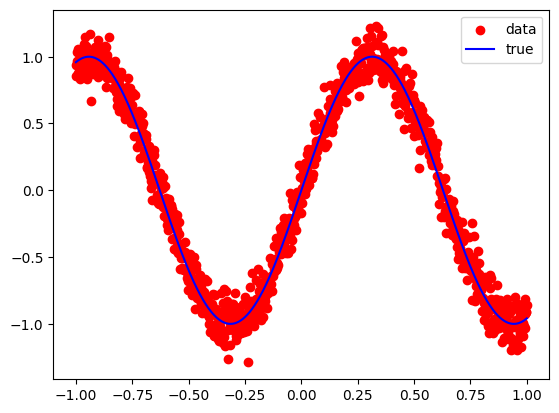

In [110]:
key, subkey = random.split(key)
xs = jnp.linspace(-1, 1, 1000).reshape(-1, 1)
true_ys = jnp.sin(5 * xs)
noise_std = 0.1
noisy_ys = jnp.sin(5 * xs) + noise_std * random.normal(key=subkey, shape=xs.shape)
plt.scatter(xs, noisy_ys, color='red', label='data')
plt.plot(xs, true_ys, color='blue', label='true')
plt.legend()

### 2.3 Loss function

In [111]:
def loss_one_point(params, x, y):
    y_pred = apply(params, x)
    return ((y_pred - y) ** 2).reshape()


def loss(params, xs, ys):
    losses = vmap(loss_one_point, in_axes=(None, 0, 0))(params, xs, ys)
    return jnp.mean(losses)

### 2.4 Optimizer and training loop

In [112]:
import optax

In [113]:
optimizer = optax.adam(learning_rate=0.01)


@jit
def update_step(xs, ys, opt_state, params):
    # Compute current value of the loss and the gradient with respect to parameters
    loss_value, grads = value_and_grad(loss, argnums=0)(params, xs, ys)

    # Do gradient descent with optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return opt_state, params, loss_value

In [114]:
key, subkey = random.split(key)
params = model.init(subkey, jnp.ones(shape=(1,)))
opt_state = optimizer.init(params)

num_steps = 1000
for i in range(num_steps):
    opt_state, params, loss_value = update_step(xs, noisy_ys, opt_state, params)
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss_value}')

Loss at step 0: 0.5326516628265381
Loss at step 100: 0.010540908202528954
Loss at step 200: 0.010414819233119488
Loss at step 300: 0.010384205728769302
Loss at step 400: 0.010369108989834785
Loss at step 500: 0.010361198335886002
Loss at step 600: 0.010356034152209759
Loss at step 700: 0.010366053320467472
Loss at step 800: 0.010357892140746117
Loss at step 900: 0.01035236194729805


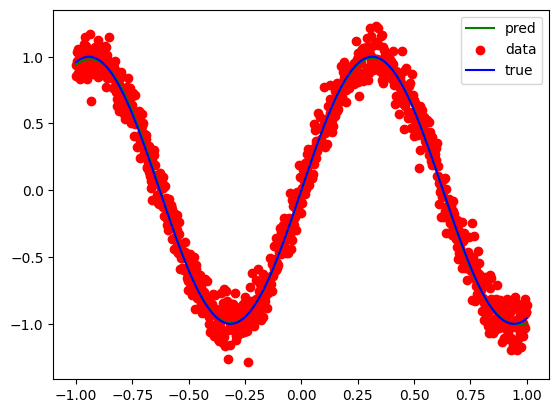

In [115]:
pred_ys = vmap(apply, in_axes=(None, 0))(params, xs)
plt.plot(xs, pred_ys, color='green', label='pred')
plt.scatter(xs, noisy_ys, color='red', label='data')
plt.plot(xs, true_ys, color='blue', label='true')
plt.legend()

### 2.5 Data Loading

Jax does not have a built-in data loader, but we can use tensorflow datasets

In [116]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [117]:
shuffle = True
infinite = True
batch_size = 64

ds = tf.data.Dataset.from_tensor_slices((xs, noisy_ys))
if shuffle:
    seed = 0
    ds = ds.shuffle(buffer_size=4 * batch_size, seed=seed, reshuffle_each_iteration=True)
if infinite:
    ds = ds.repeat()
ds = ds.batch(batch_size)
ds = tfds.as_numpy(ds)

In [118]:
for index, batch in enumerate(ds):
    print(jtu.tree_map(lambda x: x.shape, batch))
    if index == 3:
        break

((64, 1), (64, 1))
((64, 1), (64, 1))
((64, 1), (64, 1))
((64, 1), (64, 1))


In [119]:
key, subkey = random.split(key)
params = model.init(subkey, jnp.ones(shape=(1,)))
opt_state = optimizer.init(params)

num_steps = 1000
for i, (batch_xs, batch_ys) in enumerate(ds):
    opt_state, params, loss_value = update_step(batch_xs, batch_ys, opt_state, params)
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss_value}')
    if i == num_steps:
        break

Loss at step 0: 0.6633486151695251
Loss at step 100: 0.20712795853614807
Loss at step 200: 0.0771457850933075
Loss at step 300: 0.017175547778606415
Loss at step 400: 0.01396497804671526
Loss at step 500: 0.06831662356853485
Loss at step 600: 0.01403716392815113
Loss at step 700: 0.027678053826093674
Loss at step 800: 0.02301616594195366
Loss at step 900: 0.015885910019278526
Loss at step 1000: 0.017688363790512085


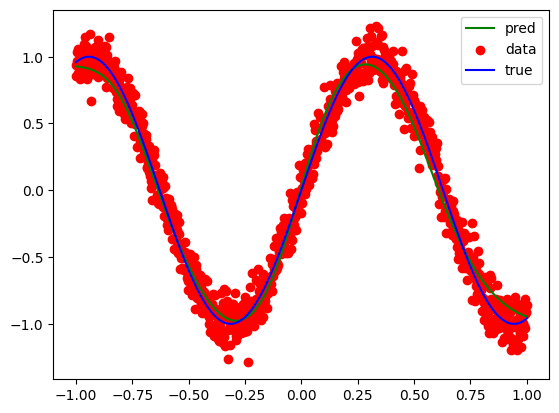

In [120]:
pred_ys = vmap(apply, in_axes=(None, 0))(params, xs)
plt.plot(xs, pred_ys, color='green', label='pred')
plt.scatter(xs, noisy_ys, color='red', label='data')
plt.plot(xs, true_ys, color='blue', label='true')
plt.legend()

### 2.6 Logging and metrics

In [121]:
import wandb

In [122]:
key, subkey = random.split(key)
params = model.init(subkey, jnp.ones(shape=(1,)))
opt_state = optimizer.init(params)

wandb.init(project="Tutorial")

num_steps = 1000
for i, (batch_xs, batch_ys) in enumerate(ds):
    opt_state, params, loss_value = update_step(batch_xs, batch_ys, opt_state, params)
    wandb.log({'loss': loss_value})
    if i % 100 == 0:
        pred_ys = vmap(apply, in_axes=(None, 0))(params, xs)
        fig, ax = plt.subplots()
        ax.plot(xs, pred_ys, color='green', label='pred')
        ax.scatter(xs, noisy_ys, color='red', label='data')
        ax.plot(xs, true_ys, color='blue', label='true')
        ax.legend()
        wandb.log({'Prediction at step {}'.format(i): wandb.Image(fig)})
        plt.close()
    if i == num_steps:
        break
wandb.finish()

loss,██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.01991
